In [22]:

import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from madry_mnist_challenge import pgd_attack

# RESULTS_DIR = '/tmp/berg-results/devboxes/madry_mnist_challenge/attack_cw_tcu'
RESULTS_DIR = '/tmp/berg-results/devboxes/madry_mnist_challenge'
%config InlineBackend.figure_format = 'svg'

def show(x):
    x = x.reshape(28, 28)
    plt.axis('off')
    plt.imshow(x, cmap='gray')
    plt.show()


In [23]:
! berg-results fetch -r -d /tmp/berg-results devboxes/madry_mnist_challenge

DEBUG:berg:Running command: gsutil -m rsync -r -x ".*.ckpt" gs://tomfeelslucky-experiments/berg_results/devboxes/madry_mnist_challenge /tmp/berg-results/devboxes/madry_mnist_challenge
Building synchronization state...
Starting synchronization...
Copying gs://tomfeelslucky-experiments/berg_results/devboxes/madry_mnist_challenge/attack_cw_tcu/attack.npy...
Copying gs://tomfeelslucky-experiments/berg_results/devboxes/madry_mnist_challenge/attack_cw_tcu/logits.npy...
Copying gs://tomfeelslucky-experiments/berg_results/devboxes/madry_mnist_challenge/attack_cw_tcu/pred.npy...
Copying gs://tomfeelslucky-experiments/berg_results/devboxes/madry_mnist_challenge/attack_cw_tcu/y_true.npy...
\ [4/4 files][ 60.3 MiB/ 60.3 MiB] 100% Done                                    
Operation completed over 4 objects/60.3 MiB.                                     
Copied to /tmp/berg-results/devboxes/madry_mnist_challenge


## Results on all classes

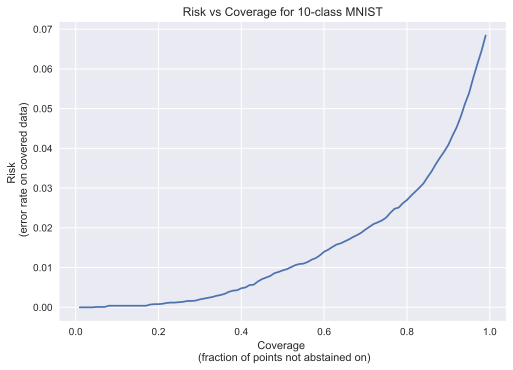

In [32]:
# Load logits
logits = np.load(os.path.join(RESULTS_DIR, 'logits.npy'))
y_true = np.load(os.path.join(RESULTS_DIR, 'y_true.npy'))

labels = np.argmax(logits, axis=1)
confidences = np.max(logits, axis=1)

def plot_confident_error_rate(labels, confidences, y_true, title="Risk vs Coverage"):
    sorted_confidences = list(sorted(confidences, reverse=True))

    coverages = np.linspace(0.01, .99, 99)
    cov_to_confident_error_idxs = []

    for coverage in coverages:    
        threshold = sorted_confidences[int(coverage * len(labels))]
        confident_mask = confidences >= threshold
        confident_error_mask = (y_true != labels) * confident_mask
        confident_error_idx = confident_error_mask.nonzero()[0]
        
        cov_to_confident_error_idxs.append(confident_error_idx)
        
    plt.plot(coverages, [float(len(idxs)) / len(labels) for idxs in cov_to_confident_error_idxs])
    plt.title(title)
    plt.ylabel("Risk \n (error rate on covered data)")
    plt.xlabel("Coverage \n (fraction of points not abstained on)")

    plt.show()
    return cov_to_confident_error_idxs
    
_ = plot_confident_error_rate(
    labels, confidences, y_true, title="Risk vs Coverage for 10-class MNIST")

## Results on TCU-MNIST

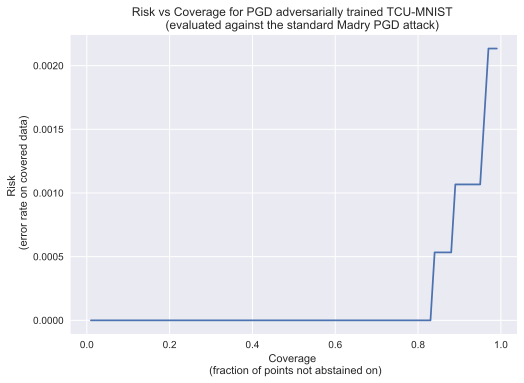

In [33]:
logits = np.load(os.path.join(RESULTS_DIR, 'logits.npy'))
y_true = np.load(os.path.join(RESULTS_DIR, 'y_true.npy'))

def softmax(logits):
    tmp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return tmp / np.sum(tmp, axis=1, keepdims=True)

# Choose two easy labels to define TCU-MNIST
VALID_LABELS = [4, 5]

# Remove all datapoints from other classes
filtered_idxs = []
for label in VALID_LABELS:
    filtered_idxs += list((y_true == label).nonzero()[0])
filtered_logits = logits[filtered_idxs]
filtered_y_true = y_true[filtered_idxs]

filtered_idx_to_original_idx = np.array(list(range(len(logits))))[filtered_idxs]

# Take the softmax and then set invalid labels to zero
probs = softmax(filtered_logits)
invalid_labels = list(set(range(10)) - set(VALID_LABELS))
probs[:, invalid_labels] = 0.

filtered_labels = np.argmax(probs, axis=1)

use_diff = False # Get slightly improved performance by taking the diff of the two logits
if use_diff:
    sorted_probs = np.sort(probs, axis=1)
    confidences = np.abs(sorted_probs[:, -1] - sorted_probs[:, -2])
else: 
    confidences = np.max(probs, axis=1)


cov_to_confident_error_idxs = plot_confident_error_rate(
    filtered_labels, confidences, filtered_y_true,  title="Risk vs Coverage for PGD adversarially trained TCU-MNIST \n \
    (evaluated against the standard Madry PGD attack)")

In [34]:
adv_xs = np.load(os.path.join(RESULTS_DIR, 'attack.npy'))

In [35]:
bad_orig_idxs = filtered_idx_to_original_idx[cov_to_confident_error_idxs[-1]]
print(bad_orig_idxs)

[7473  951 3117 3702]


At 100% coverage, there was an error on validation image #7473
True class: 4


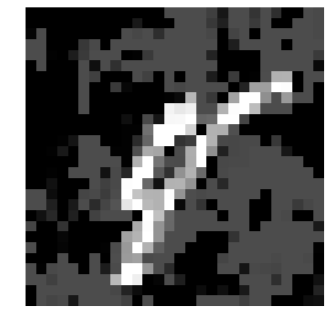

At 100% coverage, there was an error on validation image #951
True class: 5


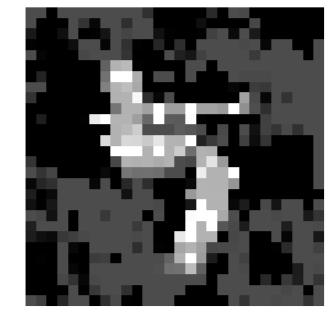

At 100% coverage, there was an error on validation image #3117
True class: 5


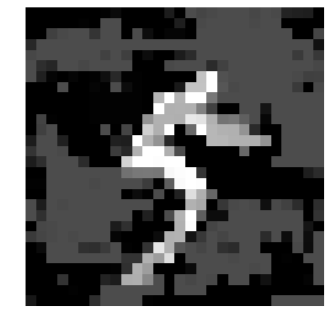

At 100% coverage, there was an error on validation image #3702
True class: 5


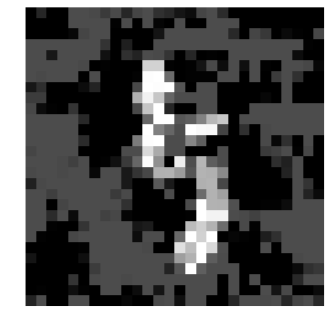

In [37]:
for bad_idx in bad_orig_idxs:
    print(f"At 100% coverage, there was an error on validation image #{bad_idx}")
    print(f"True class: {y_true[bad_idx]}")
    show(adv_xs[bad_idx])